
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import torch.utils.model_zoo as model_zoo
import torch.hub
from torch.hub import load_state_dict_from_url
from torch.autograd import Function
import copy

import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import ParameterGrid

**Set Arguments**

In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down


ALPHA = 0.01

**Define Data Preprocessing**

In [3]:
# Define transforms
transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])

**Prepare Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git
  
DATA_DIR = 'Homework3-PACS/PACS'

# Prepare Pytorch train/test Datasets
# Photo
source_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'/photo', transform=transform)
# Art
target_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'/art_painting', transform=transform)

# Validation
# Cartoon
target_val_dataset1 = torchvision.datasets.ImageFolder(DATA_DIR+'/cartoon', transform=transform)
# Sketch
target_val_dataset2 = torchvision.datasets.ImageFolder(DATA_DIR+'/sketch', transform=transform)


# Check dataset sizes
print('Source Dataset - Photo: {}'.format(len(source_dataset)))
print('Target Dataset - Art Painting: {}'.format(len(target_dataset)))

print('Validation Dataset 1 - Cartoon: {}'.format(len(target_val_dataset1)))
print('Validation Dataset 2 - Sketch: {}'.format(len(target_val_dataset2)))

Source Dataset - Photo: 1670
Target Dataset - Art Painting: 2048
Validation Dataset 1 - Cartoon: 2344
Validation Dataset 2 - Sketch: 3929


**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
source_dataloader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

target_val_dataloader1 = DataLoader(target_val_dataset1, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
target_val_dataloader2 = DataLoader(target_val_dataset2, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [6]:
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN(nn.Module):

    def __init__(self, num_classes=1000):
        super(DANN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential( #Gy
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes), #1000 output neurons (ImageNet classes)
        )

        self.Gd = nn.Sequential( #Gd
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2), #2 output neurons
        )

    def forward(self, x, alpha=None):
        
        if alpha is not None:
          x = self.features(x)
          x = ReverseLayerF.apply(x, alpha)
          x = self.avgpool(x)
          x = torch.flatten(x, 1)
          x = self.Gd(x)
          return x # discriminator outputs
        else:
          x = self.features(x)
          x = self.avgpool(x)
          x = torch.flatten(x, 1)
          x = self.classifier(x)
          return x # class outputs


def dann(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = DANN(**kwargs)

    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)

        model.Gd[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
        model.Gd[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)
        model.Gd[4].weight.data = copy.deepcopy(model.classifier[4].weight.data)
        model.Gd[4].bias.data = copy.deepcopy(model.classifier[4].bias.data)

    model.classifier[6] = nn.Linear(4096, 7)

    return model

**Prepare Training**

In [7]:
net = dann(pretrained=True, progress=False)

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train without adaptation**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    
    
    optimizer.step() # update weights based on accumulated gradients


  losses.append(loss.item())
  
  print("Loss: {}".format(loss.item()))

  # Step the scheduler
  scheduler.step()

In [ ]:
def plotWithoutAdaptation(losses, NUM_EPOCHS):
  # Plot without adaptation
  x = np.arange(1, NUM_EPOCHS+1)
  plt.plot(x, losses, label="Training")
  plt.legend() #loc="upper right"
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss trend")
  plt.grid(axis="y")
  plt.show()

In [ ]:
plotWithoutAdaptation(losses, NUM_EPOCHS)

**Test**

In [8]:
def test(net, DEVICE, target_dataloader, size_target_dataset):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in tqdm(target_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(size_target_dataset)

  print('Test Accuracy: {}'.format(accuracy))

In [ ]:
test(net, DEVICE, target_dataloader, len(target_dataset))

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]

Test Accuracy: 0.4921875


**Train with adaptation**

In [ ]:
net = net.to(DEVICE)

cudnn.benchmark

loss_sc = [] # source class
loss_sd = [] # source domain
loss_td = [] # target domain

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the target dataset
  for image, label in target_dataloader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
  
    images, labels = next(iter(source_dataloader)) # get a single batch of the source dataset (the smallest one)
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() 

    optimizer.zero_grad()

    # STEP 1 
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward() 
    
    # STEP 2
    outputs2 = net(images, alpha=ALPHA)
    labels2 = torch.zeros(len(labels)).long().to(DEVICE)
    loss2 = criterion(outputs2, labels2)
    loss2.backward()

    # STEP 3
    outputs3 = net(image, alpha=ALPHA)
    labels3 = torch.ones(len(label)).long().to(DEVICE)
    loss3 = criterion(outputs3, labels3)
    loss3.backward()
    
    optimizer.step()


  loss_sc.append(loss.item())
  print("Source class loss: {}".format(loss.item()))
  loss_sd.append(loss2.item())
  print("Source domain loss: {}".format(loss2.item()))
  loss_td.append(loss3.item())
  print("Target domain loss: {}".format(loss3.item()))

  scheduler.step()

Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Source class loss: 0.5728792548179626
Source domain loss: 0.30617082118988037
Target domain loss: 0.19320067763328552
Starting epoch 2/30, LR = [0.001]
Source class loss: 0.19653888046741486
Source domain loss: 0.11650365591049194
Target domain loss: 0.1325538009405136
Starting epoch 3/30, LR = [0.001]
Source class loss: 0.14657074213027954
Source domain loss: 0.3090277910232544
Target domain loss: 0.020938904955983162
Starting epoch 4/30, LR = [0.001]
Source class loss: 0.06652837991714478
Source domain loss: 0.1716528832912445
Target domain loss: 0.024447493255138397
Starting epoch 5/30, LR = [0.001]
Source class loss: 0.10354679822921753
Source domain loss: 0.21504707634449005
Target domain loss: 0.01771535724401474
Starting epoch 6/30, LR = [0.001]
Source class loss: 0.08558483421802521
Source domain loss: 0.13177992403507233
Target domain loss: 0.02538699470460415
Starting epoch 7/30, LR = [0.001]
Source class loss: 0.036608804017305374
Source domain loss: 0.07393033057451248
Targ

In [10]:
def plotWithAdaptation(loss_sc, loss_sd, loss_td, NUM_EPOCHS):
  # Plot with adaptation
  x = np.arange(1, NUM_EPOCHS+1)
  plt.plot(x, loss_sc, label="Source class")
  plt.plot(x, loss_sd, label="Source domain")
  plt.plot(x, loss_td, label="Target domain")
  plt.legend() #loc="upper right"
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss trend")
  plt.grid(axis="y")
  plt.show()

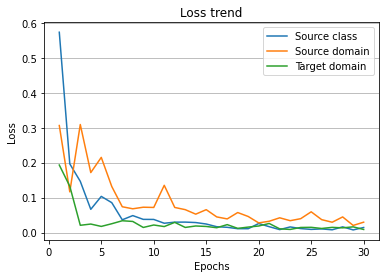

In [ ]:
plotWithAdaptation(loss_sc, loss_sd, loss_td, NUM_EPOCHS)

**Test**

In [ ]:
test(net, DEVICE, target_dataloader, len(target_dataset))

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]

Test Accuracy: 0.5068359375


**Cross Domain Validation without adaptation**

In [ ]:
# VALIDARE ANCHE SUGLI ALTRI HYPERPARAMETRI E SALVARE L'ACCURACY PIù ALTA
# DI OGNI COMBINAZIONE DI VALORI

lr = [0.001, 0.01]
num_epochs = [20, 30]
step_size = [10, 20]

params_grid = {
    "LearningRate": lr,
    "Epochs": num_epochs,
    "Step_size": step_size
}

best_accuracy = 0.0
best_lr = 0
best_num_epochs = 0
best_step_size = 0

for p in ParameterGrid(params_grid):
  LR = p["LearningRate"]
  NUM_EPOCHS = p["Epochs"]
  STEP_SIZE = p["Step_size"]
  print(f"Learning rate: {LR}, Number of Epochs: {NUM_EPOCHS}, Step size: {STEP_SIZE}")

  net = dann(pretrained=True, progress=False)
  criterion = nn.CrossEntropyLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  losses_train = []
  losses_valid = []
  accuracies_train = []
  accuracies_valid = []

  net = net.to(DEVICE) 
  
  cudnn.benchmark

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}, NUM_EPOCHS = {}, STEP_SIZE = {}'.format(epoch+1, NUM_EPOCHS, LR, NUM_EPOCHS, STEP_SIZE))
    
    # TRAINING
    counterLosses_train = 0
    running_corrects_train = 0
    for images, labels in source_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train()

      optimizer.zero_grad()

      outputs = net(images)

      _, preds = torch.max(outputs.data, 1)

      running_corrects_train += torch.sum(preds == labels.data).data.item()

      loss = criterion(outputs, labels)
      counterLosses_train += loss.item()*images.size(0)

      loss.backward()
    
      optimizer.step()

    loss_train = counterLosses_train/float(len(source_dataset))
    losses_train.append(loss_train)
    accuracy_train = running_corrects_train/float(len(source_dataset))
    accuracies_train.append(accuracy_train)

    #print("\nTrain Loss: {} Train Accuracy: {}".format(loss_train, accuracy_train)

    # VALIDATION on cartoon
    net.train(False)    

    counterLosses_cartoon = 0
    running_corrects_cartoon = 0
    for images, labels in target_val_dataloader1:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      
      outputs_cartoon = net(images)

      _, preds = torch.max(outputs_cartoon.data, 1)

      running_corrects_cartoon += torch.sum(preds == labels.data).data.item()

      loss = criterion(outputs_cartoon, labels)

      counterLosses_cartoon += loss.item()*images.size(0)
    
    accuracy_cartoon = running_corrects_cartoon/float(len(target_val_dataset1))
    loss_cartoon = counterLosses_cartoon/float(len(target_val_dataset1))


    # VALIDATION on sketch
    counterLosses_sketch = 0
    running_corrects_sketch = 0
    for images, labels in target_val_dataloader2:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      outputs_sketch = net(images)

      _, preds = torch.max(outputs_sketch.data, 1)

      running_corrects_sketch += torch.sum(preds == labels.data).data.item()

      loss = criterion(outputs_sketch, labels)

      counterLosses_sketch += loss.item()*images.size(0)
    
    accuracy_sketch = running_corrects_sketch/float(len(target_val_dataset2))
    loss_sketch = counterLosses_sketch/float(len(target_val_dataset2))

    # we calculate the average accuracy of the two validation sets
    val_accuracy = (accuracy_cartoon + accuracy_sketch)/2.0
    val_loss = (loss_cartoon + loss_sketch)/2.0

    accuracies_valid.append(val_accuracy)
    accuracies_valid.append(val_loss)

    #print("\nValid Loss: {} Valid Accuracy: {}".format(val_loss, val_accuracy)
    print("\nValid Accuracy: {}".format(val_accuracy))
    
    # salva migliore val_accuracy per ogni learning rate

    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      best_lr = LR
      best_num_epochs = NUM_EPOCHS
      best_step_size = STEP_SIZE
    
    # Step the scheduler
    scheduler.step()


print(f"\nThe best validation accuracy is {best_accuracy} with learning rate = {best_lr}, number of epochs = {best_num_epochs} and step size = {best_step_size}")


Learning rate: 0.001, Number of Epochs: 20, Step size: 10
Starting epoch 1/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.23321366803422872
Starting epoch 2/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.2357515698876908
Starting epoch 3/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.20170553997274143
Starting epoch 4/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.18713619389209668
Starting epoch 5/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.18104715135637078
Starting epoch 6/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.1825366878996384
Starting epoch 7/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.18858088580842375
Starting epoch 8/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.19662365563843548
Starting epoch 9/20, LR = 0.001, NUM_EPOCHS = 20, STEP_SIZE = 10

Valid Accuracy: 0.20410890794538206
Starting epoch 10/20, LR =

**Train with best hyperparameters**

In [ ]:
LR = best_lr
NUM_EPOCHS = best_num_epochs
STEP_SIZE = best_step_size

net = dann(pretrained=True, progress=False)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net = net.to(DEVICE)

cudnn.benchmark

losses = []

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  for images, labels in source_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()

    optimizer.zero_grad()

    outputs = net(images)

    loss = criterion(outputs, labels)

    loss.backward()
    
    
    optimizer.step()

  losses.append(loss.item())
  
  print("Loss: {}".format(loss.item()))

  scheduler.step()

Starting epoch 1/20, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Loss: 0.19738152623176575
Starting epoch 2/20, LR = [0.01]
Loss: 0.2841759920120239
Starting epoch 3/20, LR = [0.01]
Loss: 0.09191185981035233
Starting epoch 4/20, LR = [0.01]
Loss: 0.05950929597020149
Starting epoch 5/20, LR = [0.01]
Loss: 0.03632397577166557
Starting epoch 6/20, LR = [0.01]
Loss: 0.056191980838775635
Starting epoch 7/20, LR = [0.01]
Loss: 0.01473560743033886
Starting epoch 8/20, LR = [0.01]
Loss: 0.0022017229348421097
Starting epoch 9/20, LR = [0.01]
Loss: 0.006302798166871071
Starting epoch 10/20, LR = [0.01]
Loss: 0.020154161378741264
Starting epoch 11/20, LR = [0.01]
Loss: 0.004095315933227539
Starting epoch 12/20, LR = [0.01]
Loss: 0.0035316646099090576
Starting epoch 13/20, LR = [0.01]
Loss: 0.0014383234083652496
Starting epoch 14/20, LR = [0.01]
Loss: 0.0017032753676176071
Starting epoch 15/20, LR = [0.01]
Loss: 0.0012863371521234512
Starting epoch 16/20, LR = [0.01]
Loss: 0.001525677740573883
Starting epoch 17/20, LR = [0.01]
Loss: 0.004292704164981842
Startin

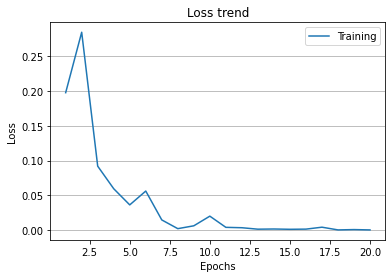

In [ ]:
plotWithoutAdaptation(losses, NUM_EPOCHS)

**Test**

In [ ]:
test(net, DEVICE, target_dataloader, len(target_dataset))

100%|██████████| 8/8 [00:07<00:00,  1.05it/s]

Test Accuracy: 0.509765625


**Cross Domain Validation with adaptation**

In [10]:
# CARTOON
lr = [0.001, 0.01]
alpha = [0.01, 0.03, 0.5]

params_grid = {
    "LearningRate": lr,
    "Alpha": alpha
}
NUM_EPOCHS = 10
accuracy_tot = []

for p in ParameterGrid(params_grid):
  LR = p["LearningRate"]
  ALPHA = p["Alpha"]
  print(f"Learning rate: {LR}, Alpha: {ALPHA}")

  net = dann(pretrained=True, progress=False)
  criterion = nn.CrossEntropyLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  net = net.to(DEVICE) 
  cudnn.benchmark

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}, alpha = {}'.format(epoch+1, NUM_EPOCHS, LR, ALPHA))

    for image, label in target_val_dataloader1: # passa target
      image = image.to(DEVICE)
      label = label.to(DEVICE)
    
      images, labels = next(iter(source_dataloader)) # get a single batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train()

      optimizer.zero_grad()

      # STEP 1
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()
    
      # STEP 2
      outputs2 = net(images, alpha=ALPHA)
      labels2 = torch.zeros(len(labels)).long().to(DEVICE)
      loss2 = criterion(outputs2, labels2)
      loss2.backward()

      # STEP 3
      outputs3 = net(image, alpha=ALPHA)
      labels3 = torch.ones(len(label)).long().to(DEVICE)
      loss3 = criterion(outputs3, labels3)
      loss3.backward()
    
      optimizer.step()

    # VALIDATION on cartoon
    net.train(False)    

    running_corrects = 0
    for images, labels in target_val_dataloader1: # passa target
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      
      outputs = net(images)

      _, preds = torch.max(outputs.data, 1)

      running_corrects += torch.sum(preds == labels.data).data.item()

      loss = criterion(outputs, labels)

    
    accuracy = running_corrects/float(len(target_val_dataset1)) # passa target

    print(accuracy)

    accuracy_tot.append(accuracy)


    # Step the scheduler
    scheduler.step()

#print(f"\nThe best validation accuracy is {best_accuracy} with learning rate = {best_lr} and alpha = {best_alpha}")

Learning rate: 0.001, Alpha: 0.01
Starting epoch 1/10, LR = 0.001, alpha = 0.01
0.25554607508532423
Starting epoch 2/10, LR = 0.001, alpha = 0.01
0.24232081911262798
Starting epoch 3/10, LR = 0.001, alpha = 0.01
0.24829351535836178
Starting epoch 4/10, LR = 0.001, alpha = 0.01
0.25426621160409557
Starting epoch 5/10, LR = 0.001, alpha = 0.01
0.23976109215017063
Starting epoch 6/10, LR = 0.001, alpha = 0.01
0.23506825938566553
Starting epoch 7/10, LR = 0.001, alpha = 0.01
0.253839590443686
Starting epoch 8/10, LR = 0.001, alpha = 0.01
0.25
Starting epoch 9/10, LR = 0.001, alpha = 0.01
0.24786689419795221
Starting epoch 10/10, LR = 0.001, alpha = 0.01
0.25853242320819114
Learning rate: 0.01, Alpha: 0.01
Starting epoch 1/10, LR = 0.01, alpha = 0.01
0.2815699658703072
Starting epoch 2/10, LR = 0.01, alpha = 0.01
0.2273890784982935
Starting epoch 3/10, LR = 0.01, alpha = 0.01
0.32081911262798635
Starting epoch 4/10, LR = 0.01, alpha = 0.01
0.2572525597269625
Starting epoch 5/10, LR = 0.01, 

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-83i5bvg0'


0.1659556313993174
Starting epoch 6/10, LR = 0.01, alpha = 0.5
0.1659556313993174
Starting epoch 7/10, LR = 0.01, alpha = 0.5
0.1659556313993174
Starting epoch 8/10, LR = 0.01, alpha = 0.5
0.1659556313993174
Starting epoch 9/10, LR = 0.01, alpha = 0.5
0.1659556313993174
Starting epoch 10/10, LR = 0.01, alpha = 0.5
0.1659556313993174


In [11]:
# SKETCH
lr = [0.001, 0.01]
alpha = [0.01, 0.03, 0.5]

params_grid = {
    "LearningRate": lr,
    "Alpha": alpha
}
NUM_EPOCHS = 10
accuracy_tot = []

for p in ParameterGrid(params_grid):
  LR = p["LearningRate"]
  ALPHA = p["Alpha"]
  print(f"Learning rate: {LR}, Alpha: {ALPHA}")

  net = dann(pretrained=True, progress=False)
  criterion = nn.CrossEntropyLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  net = net.to(DEVICE) 
  cudnn.benchmark

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}, alpha = {}'.format(epoch+1, NUM_EPOCHS, LR, ALPHA))

    for image, label in target_val_dataloader2: # passa target
      image = image.to(DEVICE)
      label = label.to(DEVICE)
    
      images, labels = next(iter(source_dataloader)) # get a single batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train()

      optimizer.zero_grad()

      # STEP 1
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()
    
      # STEP 2
      outputs2 = net(images, alpha=ALPHA)
      labels2 = torch.zeros(len(labels)).long().to(DEVICE)
      loss2 = criterion(outputs2, labels2)
      loss2.backward()

      # STEP 3
      outputs3 = net(image, alpha=ALPHA)
      labels3 = torch.ones(len(label)).long().to(DEVICE)
      loss3 = criterion(outputs3, labels3)
      loss3.backward()
    
      optimizer.step()

    # VALIDATION on sketch
    net.train(False)    

    running_corrects = 0
    for images, labels in target_val_dataloader2: # passa target
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      
      outputs = net(images)

      _, preds = torch.max(outputs.data, 1)

      running_corrects += torch.sum(preds == labels.data).data.item()

      loss = criterion(outputs, labels)

    
    accuracy = running_corrects/float(len(target_val_dataset2)) # passa target

    print(accuracy)

    accuracy_tot.append(accuracy)


    # Step the scheduler
    scheduler.step()

#print(f"\nThe best validation accuracy is {best_accuracy} with learning rate = {best_lr} and alpha = {best_alpha}")

Learning rate: 0.001, Alpha: 0.01
Starting epoch 1/10, LR = 0.001, alpha = 0.01
0.17154492237210486
Starting epoch 2/10, LR = 0.001, alpha = 0.01
0.18019852379740392
Starting epoch 3/10, LR = 0.001, alpha = 0.01
0.17510817001781623
Starting epoch 4/10, LR = 0.001, alpha = 0.01
0.1901247136675999
Starting epoch 5/10, LR = 0.001, alpha = 0.01
0.19546958513616697
Starting epoch 6/10, LR = 0.001, alpha = 0.01
0.19037923135657928
Starting epoch 7/10, LR = 0.001, alpha = 0.01
0.19776024433698142
Starting epoch 8/10, LR = 0.001, alpha = 0.01
0.20412318656146602
Starting epoch 9/10, LR = 0.001, alpha = 0.01
0.19928735047085772
Starting epoch 10/10, LR = 0.001, alpha = 0.01
0.2043777042504454
Learning rate: 0.01, Alpha: 0.01
Starting epoch 1/10, LR = 0.01, alpha = 0.01
0.31356579282260116
Starting epoch 2/10, LR = 0.01, alpha = 0.01
0.31102061593280733
Starting epoch 3/10, LR = 0.01, alpha = 0.01
0.3308729956731993
Starting epoch 4/10, LR = 0.01, alpha = 0.01
0.3405446678544159
Starting epoch 5

**Train with best hyperparameters**

In [16]:
NUM_EPOCHS = 10
LR = 0.01
ALPHA = 0.03

net = dann(pretrained=True, progress=False)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net = net.to(DEVICE)

cudnn.benchmark

loss_sc = [] # source class
loss_sd = [] # source domain
loss_td = [] # target domain

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}, alpha = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr(), ALPHA))

  # Iterate over the dataset
  for image, label in target_dataloader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    
    images, labels = next(iter(source_dataloader)) # get a single batch
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()

    optimizer.zero_grad()

    # STEP 1
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    
    # STEP 2
    outputs2 = net(images, alpha=ALPHA)
    labels2 = torch.zeros(len(labels)).long().to(DEVICE)
    loss2 = criterion(outputs2, labels2)
    loss2.backward()

    # STEP 3
    outputs3 = net(image, alpha=ALPHA)
    labels3 = torch.ones(len(label)).long().to(DEVICE)
    loss3 = criterion(outputs3, labels3)
    loss3.backward()
    
    optimizer.step()

  loss_sc.append(loss.item())
  print("Source class loss: {}".format(loss.item()))
  loss_sd.append(loss2.item())
  print("Source domain loss: {}".format(loss2.item()))
  loss_td.append(loss3.item())
  print("Target domain loss: {}".format(loss3.item()))

  scheduler.step()

Starting epoch 1/10, LR = [0.01], alpha = 0.03


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Source class loss: 0.18946555256843567
Source domain loss: 1.0289108753204346
Target domain loss: 0.10294658690690994
Starting epoch 2/10, LR = [0.01], alpha = 0.03
Source class loss: 0.05911470949649811
Source domain loss: 0.8530290722846985
Target domain loss: 0.25897297263145447
Starting epoch 3/10, LR = [0.01], alpha = 0.03
Source class loss: 0.06926006823778152
Source domain loss: 0.2459665834903717
Target domain loss: 0.027493776753544807
Starting epoch 4/10, LR = [0.01], alpha = 0.03
Source class loss: 0.042487096041440964
Source domain loss: 0.10286474972963333
Target domain loss: 0.10004913806915283
Starting epoch 5/10, LR = [0.01], alpha = 0.03
Source class loss: 0.06547592580318451
Source domain loss: 0.09324278682470322
Target domain loss: 0.1574113667011261
Starting epoch 6/10, LR = [0.01], alpha = 0.03
Source class loss: 0.018816957250237465
Source domain loss: 0.044851504266262054
Target domain loss: 0.04150361567735672
Starting epoch 7/10, LR = [0.01], alpha = 0.03
Sour

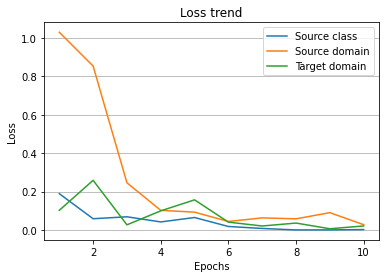

In [17]:
x = np.arange(1, NUM_EPOCHS+1)
plt.plot(x, loss_sc, label="Source class")
plt.plot(x, loss_sd, label="Source domain")
plt.plot(x, loss_td, label="Target domain")
plt.legend() #loc="upper right"
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss trend")
plt.grid(axis="y")
plt.show()

**Test**

In [18]:
test(net, "cpu", target_dataloader, len(target_dataset))

100%|██████████| 8/8 [01:06<00:00,  8.34s/it]

Test Accuracy: 0.52880859375
